In [1]:
import numpy as np
import os, shutil
import time
import matplotlib.pyplot as plt


from keras.models import load_model


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

C:\Users\axele\anaconda3\envs\MLDL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Transformer le modèle keras h5 en pytorch

In [ ]:
#Recreer un modele pytorch pour stocker notre modèle keras dedans

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)  

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, h):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, h)
        self.fc2 = nn.Linear(h, h)
        self.fc3 = nn.Linear(h, h)
        self.fc4 = nn.Linear(h, h)
        self.fc5 = nn.Linear(h, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(*hidden_init(self.fc4))
        self.fc5.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        return F.tanh(self.fc5(x))

net=Actor(1,1,time.time(),32)

In [ ]:
#On charge le modele
model = load_model('tomnod_everything_relu_Adam.h5')

#On recupere ses poids
weights=model.get_weights()

#On transpose les poids dans le modèle pytorch
net.fc1.weight.data=torch.from_numpy(np.transpose(weights[0]))
net.fc1.bias.data=torch.from_numpy(weights[1])
net.fc2.weight.data=torch.from_numpy(np.transpose(weights[2]))
net.fc2.bias.data=torch.from_numpy(weights[3])
net.fc3.weight.data=torch.from_numpy(np.transpose(weights[4]))
net.fc3.bias.data=torch.from_numpy(weights[5])
net.fc4.weight.data=torch.from_numpy(np.transpose(weights[6]))
net.fc4.bias.data=torch.from_numpy(weights[7])
net.fc5.weight.data=torch.from_numpy(np.transpose(weights[8]))
net.fc5.bias.data=torch.from_numpy(weights[9])

In [ ]:
#On enregistre le modèle
torch.save(net.state_dict(), 'model_article.pth')

## Torchvision exemple


In [4]:
#Definir la fonction de transformation
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Définir le jeu de données d'entraînement (par exemple CIFAR10)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) 

# Définir le DataLoader pour les données d'entraînement
train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, num_workers=0)

Files already downloaded and verified


## Torchvision avec le modèle de l'article


In [6]:
#Chargement du jeu de données
original_dataset_dir = r'C:\Users\axele\OneDrive\Documents\Projet_MLDL'

train_damage_dir = original_dataset_dir + '/train_another/damage'
validation_damage_dir = original_dataset_dir + '/validation_another/damage'
test_damage_dir = original_dataset_dir + '/test/damage'

train_nodamage_dir = original_dataset_dir + '/train_another/no_damage'
validation_nodamage_dir = original_dataset_dir + '/validation_another/no_damage'
test_nodamage_dir = original_dataset_dir + '/test/no_damage'

print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))


############################################################################################################
#Definir la fonction de transformation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Définir le jeu de données d'entraînement
train_dataset = ImageFolder(original_dataset_dir + '/train_another', transform=transform)

# Définir le DataLoader pour les données d'entraînement
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

val_dataset = ImageFolder(original_dataset_dir + '/validation_another', transform=transform)
validationloader = DataLoader(val_dataset, batch_size=20, shuffle=True)

total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [7]:
# Charger un modèle pré-entraîné (ici ResNet18)
model = torchvision.models.resnet18(weights=True)

# Définir la dernière couche en fonction du nombre de classes dans votre jeu de données
num_classes = 2 # nombre de classes
model.fc = nn.Linear(512, num_classes)

# Définir les paramètres à optimiser
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
# Configurer l'optimiseur 
optimizer = optim.Adam(params_to_update, lr=0.001)

# Définir la fonction de perte (cross-entropy)
criterion = nn.CrossEntropyLoss()

#Définir les épochs 
num_epochs = 20 

In [10]:
# Boucle d'entraînement
train_losses = []
val_accuracies = []
train_loss = 0
elapsed_time = 0

for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Valider le modèle
        if i % 100 == 99:  # tout 100 mini-batches
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for data in validationloader:
                    inputs, labels = data
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_accuracies.append(correct / total)
                print('Epoch %d mini-batch %5d validation accuracy: %.2f %%' % (
                    epoch + 1, i + 1, 100 * correct / total))
            model.train()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    elapsed_time += time.time() - start_time
    print(elapsed_time)
    print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / (i + 1)))

print('Finished Training')

Epoch 1 mini-batch   100 validation accuracy: 79.85 %
Epoch 1 mini-batch   200 validation accuracy: 96.50 %
Epoch 1 mini-batch   300 validation accuracy: 96.45 %
Epoch 1 mini-batch   400 validation accuracy: 91.60 %
Epoch 1 mini-batch   500 validation accuracy: 97.60 %
[1,   500] loss: 0.093
Epoch 2 mini-batch   100 validation accuracy: 98.00 %
Epoch 2 mini-batch   200 validation accuracy: 97.15 %
Epoch 2 mini-batch   300 validation accuracy: 96.60 %
Epoch 2 mini-batch   400 validation accuracy: 97.50 %
Epoch 2 mini-batch   500 validation accuracy: 97.30 %
[2,   500] loss: 0.070
Epoch 3 mini-batch   100 validation accuracy: 98.35 %
Epoch 3 mini-batch   200 validation accuracy: 97.70 %
Epoch 3 mini-batch   300 validation accuracy: 88.75 %
Epoch 3 mini-batch   400 validation accuracy: 90.15 %
Epoch 3 mini-batch   500 validation accuracy: 89.75 %
[3,   500] loss: 0.062
Epoch 4 mini-batch   100 validation accuracy: 93.45 %
Epoch 4 mini-batch   200 validation accuracy: 90.40 %
Epoch 4 mini-

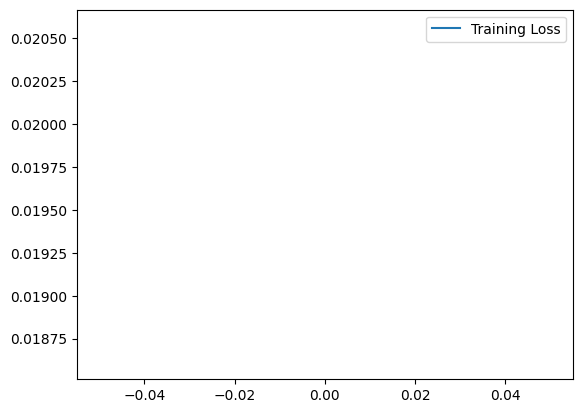

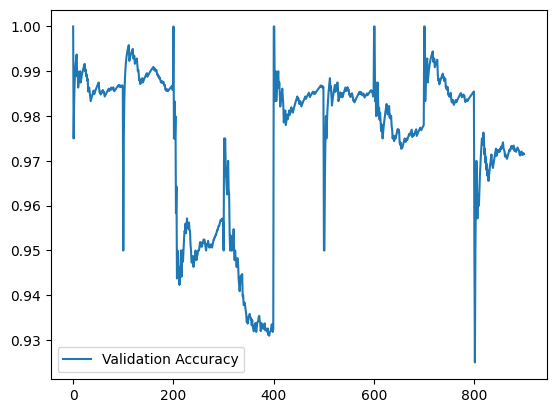

In [15]:

plt.plot(train_losses, label='Training Loss')
plt.legend()
plt.show()

plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()